In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1. Try to build a classiﬁer for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to ﬁnd good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors':[1,3,5,7,9], 'weights':['uniform','distance']}

grid_model = GridSearchCV(estimator=KNeighborsClassifier(),
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=3,
                          verbose=2)

grid_model.fit(X_train[:6000], y_train[:6000])
grid_model.best_estimator_
grid_model.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.4s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.4s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.4s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.4s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.5s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.4s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.4s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.4s
[CV] END ....................n_neighbors=3, weig

{'n_neighbors': 3, 'weights': 'distance'}

In [5]:
knn = grid_model.best_estimator_
knn

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [6]:
from sklearn.model_selection import cross_val_score

cross_val_score(knn, X_train[:6000], y_train[:6000], cv=10, scoring="accuracy")

array([0.94333333, 0.92666667, 0.94166667, 0.93833333, 0.93333333,
       0.955     , 0.94166667, 0.93      , 0.92333333, 0.955     ])

In [7]:
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9717

2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artiﬁcially growing the training set is called data augmentation or training set expansion.

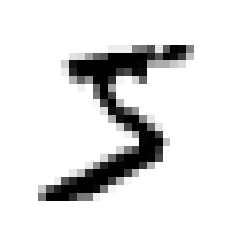

In [8]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plot_digit(X[0])

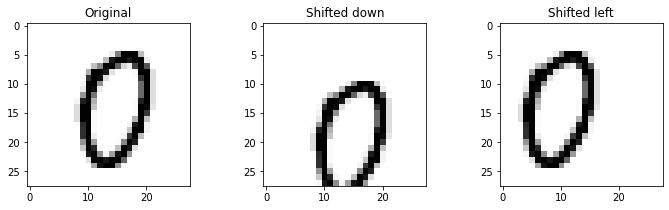

In [9]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

image = X_train[1000]  # some random digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [10]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [11]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [12]:
knn.fit(X_train_augmented, y_train_augmented)
knn.score(X_test, y_test)

0.9763